In [1]:
import pandas as pd
import numpy as np
import sys
import re
import os
import os.path
from re import search
from datetime import datetime
from os import walk
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
import CDB_Connection as cdb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest

## 1) Datasets

### 1) Masterlist

#### Loading tables

In [2]:
# Read in einspnr <-> brand relation for ZF brands
SE001 = pd.read_sql(
    """select einspnr, marke as brand
    from wekatest.se001""",
con=cdb.engine)

In [223]:
# Masterlist, selected only categorical and numeric data (no string data)
# only for brand 32
# table to test models on
# got rid of brutogewicht

masterlist = pd.read_sql(
    f"""select j1.marke as brand, t0.artnr, t0.genart_bez_en, t0.fzkat_vk_en as vehicle_type, t0.pmva, t0.nettogewicht_kg, 
        t0.laenge_mm, t0.breite_mm, t0.hoehe_mm, t0.volumen_l 
        from masterlist_all t0
        left join wekatest.se001 j1
        on t0.einspnr = j1.einspnr""",
    con = cdb.engine)

In [251]:
masterlist.to_excel("C:/Users/Z0176164/OneDrive - ZF Friedrichshafen AG/Master thesis/masterlist.xlsx")

#### Data transformations

In [225]:
masterlist["Artnr First 3"] = masterlist['artnr'].str[0:3]
masterlist.head(5)

,brand,artnr,genart_bez_en,vehicle_type,pmva,nettogewicht_kg,laenge_mm,breite_mm,hoehe_mm,volumen_l,Artnr First 3
0,SACHS,997 696,Suspension Spring,PC,0100,"4,66",564,201,201,"22,786",997
1,GIRLING,90042097,Brake Hose,PC,T001,None,None,None,None,None,900
2,LUCAS,LUC5209,Ignition Cable Kit,PC,None,None,None,None,None,None,LUC
3,WABCO,9140300020,"Brake Valve, trailer",None,0100,None,None,None,None,None,914
4,LEMFÖRDER,27173 01,"Tensioner Pulley, timing belt",PC,0100,None,None,None,None,None,271


In [226]:
masterlist_renamed = masterlist.rename(columns={'genart_bez_en':'Genart description',
                           'vehicle_type':'Vehicle Type',
                           'pmva':'PMVA',
                           'nettogewicht_kg':'Net weight',
                           'laenge_mm':'Length',
                           'breite_mm':'Width',
                           'hoehe_mm':'Height',
                           'volumen_l':'Volume',
                           'brand':'Brand',
                           'artnr':'Artnr'})

In [227]:
# Define a function to create dummy columns
def create_dummy_columns(df):
    # Extract the original columns
    original_columns = df.columns.tolist()
    original_columns.remove('Vehicle Type')  # Exclude 'Vehicle Type' from original columns
    
    # Create a set to store all unique values in the series
    unique_values = set()
    
    # Iterate over each row to extract unique values
    for value in df['Vehicle Type']:
        if value is not None:
            unique_values.update(value.split(', '))
    
    # Create dummy columns for each unique value
    dummy_columns = {}
    for value in unique_values:
        dummy_columns[value] = df['Vehicle Type'].apply(lambda x: 1 if (x is not None and value in x.split(', ')) else 0)
    
    # Combine dummy columns with original columns
    df = pd.concat([df, pd.DataFrame(dummy_columns)], axis=1)
    
    # Drop the 'Vehicle Type' column
    df.drop(columns=['Vehicle Type'], inplace=True)
    
    return df

# Call the function to create dummy columns
masterlist_with_dummies = create_dummy_columns(masterlist_renamed)

masterlist_with_dummies = masterlist_with_dummies[["Artnr","Artnr First 3","Brand","Genart description","PMVA",
                         "Net weight","Length","Width","Height",
                         "Volume","Axle","Truck","Tractor","PC","Bus"]]

masterlist_with_dummies.head(10)

,Artnr,Artnr First 3,Brand,Genart description,PMVA,Net weight,Length,Width,Height,Volume,Axle,Truck,Tractor,PC,Bus
0,997 696,997,SACHS,Suspension Spring,0100,"4,66",564,201,201,"22,786",0,0,0,1,0
1,90042097,900,GIRLING,Brake Hose,T001,None,None,None,None,None,0,0,0,1,0
2,LUC5209,LUC,LUCAS,Ignition Cable Kit,None,None,None,None,None,None,0,0,0,1,0
3,9140300020,914,WABCO,"Brake Valve, trailer",0100,None,None,None,None,None,0,0,0,0,0
4,27173 01,271,LEMFÖRDER,"Tensioner Pulley, timing belt",0100,None,None,None,None,None,0,0,0,1,0
5,1888 600 132,188,SACHS,Clutch Pressure Plate,0100,"34,16",496,461,162,"37,042",0,0,1,0,0
6,BHT266E,BHT,TRW,Brake Caliper,T001,None,None,None,None,None,0,0,0,1,0
7,4630903110,463,WABCO,Air Suspension Valve,0100,None,None,None,None,None,0,0,0,0,0
8,JGT4336S,JGT,TRW,Shock Absorber,T008,None,None,None,None,None,0,0,0,0,0
9,LRB00224,LRB,LUCAS,Alternator,None,None,None,None,None,None,0,0,0,1,0


In [228]:
columns_to_convert = ["Net weight","Length","Width","Height","Volume"]  # Replace column names with actual column names

for column in columns_to_convert:
    masterlist_with_dummies[column] = masterlist_with_dummies[column].str.replace(',', '.')

In [229]:
masterlist_with_dummies[columns_to_convert] = masterlist_with_dummies[columns_to_convert].astype(float)

In [230]:
masterlist_art = masterlist["artnr"].drop_duplicates()
print("The total number or different articles are:")
print(masterlist_art.shape[0])

The total number or different articles are:
317918


In [231]:
masterlist_with_dummies = masterlist_with_dummies.drop('Artnr', axis=1)

In [ ]:
# Replace null values differently based on data types
for col in data.columns:
    if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        data[col] = data[col].fillna(0)  # Replace null values with 0 for numerical columns
    elif data[col].dtype == 'object':
        data[col] = data[col].fillna('null')  # Replace null values with 'null' for object columns

#### Exploratory data analysis

In [232]:
print("The shape of the dataset is the following:")
print(masterlist_with_dummies.shape)

The shape of the dataset is the following:
(321529, 14)


In [233]:
# Basic statistics for numerical columns
numerical_stats = masterlist_with_dummies.iloc[:, 4:9].describe()
print("Basic statistics:")
print(numerical_stats)

Basic statistics:
        Net weight       Length         Width        Height        Volume
count  48849.00000  36592.00000  36498.000000  36517.000000  36963.000000
mean       5.09012    390.59553    211.873501    106.985835     10.352136
std       11.55247    179.99753    120.018379     52.699293     31.810557
min        0.00100      0.99000      0.990000      0.990000      0.001000
25%        1.70000    257.00000    107.000000     70.000000      2.778000
50%        2.20000    387.00000    178.000000     98.000000      6.440000
75%        4.70000    520.00000    288.000000    133.000000     13.121000
max      720.00000   1025.00000    740.000000    889.000000   5390.000000


In [234]:
# Frequency count for categorical columns
categorical_counts = {}
for col in masterlist_with_dummies.columns[0:4]:
    categorical_counts[col] = masterlist_with_dummies[col].value_counts()
    
print("\nFrequency count for categorical columns:")
for col, counts in categorical_counts.items():
    print(f"\n{col}:")
    print(counts)


Frequency count for categorical columns:

Artnr First 3:
Artnr First 3
GDB    5089
300    4844
186    4122
LRA    3645
JGM    3614
       ... 
PJS       1
609       1
877       1
H16       1
SDC       1
Name: count, Length: 1992, dtype: int64

Brand:
Brand
TRW                  77616
SACHS                56022
LEMFÖRDER            52146
WABCO                30030
LUCAS                27873
BOGE                 22757
ZF Parts             13024
Brake ENGINEERING    12955
GIRLING              12658
ZF                    5319
GABRIEL               3885
SACHS Performance      908
ProVia                 349
Name: count, dtype: int64

Genart description:
Genart description
Shock Absorber                        41467
Brake Pad Set, disc brake             13137
Brake Caliper                         12965
Brake Disc                            12954
Suspension Spring                     12289
                                      ...  
Switch, differential lock                 1
Wire Brush, brake

#### Frequency

In [235]:
# Initialize total count
def calculate_frequency(df, row_number):
    row = df.iloc[row_number]
    total_count = 0
    # Iterate over columns starting from the first column
    for column in df.columns:
        # Get the value from the first row
        first_value = row[column]

        # Count occurrences of the first value in the current column
        count = (df[column] == first_value).sum()

        # Add the count to the total count
        total_count += count

    frequency = total_count / df.size
    
    return row_number, total_count, frequency

In [236]:
# Choose here of which data object you want get the frequency
data_object = 0

row_number, total_count, frequency = calculate_frequency(masterlist_with_dummies, data_object)

print(f"The total count for data object {row_number} is {total_count}.")
print(f"The Frequency of data object {row_number} is {frequency}.")

The total count for data object 0 is 1599447.
The Frequency of data object 0 is 0.3553216483916359.


In [237]:
# Ran for 10 hours (635 min)

data = []
for i, row in masterlist_with_dummies.iterrows():
    row_number, total_count, frequency = calculate_frequency(masterlist_with_dummies, i)
    data.append({'i': i, 'frequency': frequency})
df = pd.DataFrame(data)

df.head()

,i,frequency
0,0,0.355322
1,1,0.327736
2,2,0.317435
3,3,0.348824
4,4,0.351371


In [238]:
# Row indices with lowest frequencies
sorted_df = df.sort_values(by='frequency')
sorted_df.head()

,i,frequency
151048,151048,0.122291
133776,133776,0.122307
187496,187496,0.122380
27388,27388,0.122800
48625,48625,0.123365


In [248]:
# Selecting lowest frequency rows
selected_rows = masterlist_with_dummies.iloc[[151048, 133776,187496,27388,48625]]
result_df = pd.DataFrame(selected_rows)
result_df

,Artnr First 3,Brand,Genart description,PMVA,Net weight,Length,Width,Height,Volume,Axle,Truck,Tractor,PC,Bus
151048,LWH,LUCAS,Wiper Blade,None,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1
133776,LLW,LUCAS,Wiper Blade,None,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1
187496,LEV,LUCAS,EGR Valve,None,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1
27388,LRT,LUCAS,Starter,None,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1
48625,LRS,LUCAS,Starter,None,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1


In [217]:
for i, row in masterlist_with_dummies.iterrows():
    row_number, total_count, frequency = calculate_frequency(masterlist_with_dummies, i)
    print(f"The Frequency of data object {i} is {frequency}.")

The Frequency of data object 0 is 0.37142857142857144.
The Frequency of data object 1 is 0.32857142857142857.
The Frequency of data object 2 is 0.3157142857142857.
The Frequency of data object 3 is 0.3628571428571429.
The Frequency of data object 4 is 0.3485714285714286.
The Frequency of data object 5 is 0.3057142857142857.
The Frequency of data object 6 is 0.3485714285714286.
The Frequency of data object 7 is 0.3628571428571429.
The Frequency of data object 8 is 0.35.
The Frequency of data object 9 is 0.3157142857142857.
The Frequency of data object 10 is 0.3557142857142857.
The Frequency of data object 11 is 0.33714285714285713.
The Frequency of data object 12 is 0.2885714285714286.
The Frequency of data object 13 is 0.3242857142857143.
The Frequency of data object 14 is 0.35.
The Frequency of data object 15 is 0.3242857142857143.
The Frequency of data object 16 is 0.32142857142857145.
The Frequency of data object 17 is 0.31857142857142856.
The Frequency of data object 18 is 0.364285

#### Distance measures

##### Jaccard similarity

In [337]:
# Rows to compare (index values)
row1_index = 0
row2_index = 1

# Extract values for the two rows
row1_values = set(masterlist_with_dummies.iloc[row1_index])
row2_values = set(masterlist_with_dummies.iloc[row2_index])

# Calculate Jaccard similarity
intersection = len(row1_values.intersection(row2_values)) # count the intersection between values in both rows
union = len(row1_values.union(row2_values)) # count the union between values in both rows
jaccard_similarity = intersection / union

print("Jaccard Similarity between row", row1_index, "and row", row2_index, ":", jaccard_similarity)

Jaccard Similarity between row 0 and row 1 : 0.10526315789473684


#### Distance data object to cluster

In [323]:
kmodes = masterlist_with_dummies[["Brand", "Genart description"]].sample(10).reset_index(drop=True)
kmodes

,Brand,Genart description
0,TRW,"Accessory Kit, disc brake pad"
1,BOGE,Shock Absorber
2,TRW,Brake Disc
3,SACHS,Shock Absorber
4,LUCAS,"Idle Control Valve, air supply"
5,TRW,"Central Slave Cylinder, clutch"
6,SACHS,Clutch Pressure Plate
7,SACHS,Clutch Kit
8,Brake ENGINEERING,Wheel Brake Cylinder
9,TRW,Brake Caliper


We assume the first 9 data object (index 0-8) are a cluster and data object 0 is the centroid of the cluster.
Now the question is what is the distance from object 9 to the cluster according to the distance measure in formula 2.

Calculate $f(x_{i,r}|C_{z})$

In [315]:
def calculate_attribute_freq(r):
    count = (kmodes.iloc[:,r] == kmodes.iloc[0,r]).sum()
    freq = count / kmodes.shape[0] # divide the frequency count by the number of observations
    return freq

Calculate $ϕ(x_{i,r},c_{z,r})$

In [316]:
def calculate_ϕ(r):
    if kmodes.iloc[0,r] == kmodes.iloc[9,r]:
        x = 1 - calculate_attribute_freq(r) 
    else:
        x = 1
    return x

Calculate $d(X_{i},C_{z})$

In [324]:
distance = 0

for i in range(kmodes.shape[1]):
    distance += calculate_ϕ(i)

print("Distance:", distance)

Distance: 1.6


#### Checks and fixes

In [107]:
all = masterlist_with_dummies["Genart description"].drop_duplicates()
no_truck = masterlist_with_dummies.query('Truck == 0')
no_truck = no_truck["Genart description"].drop_duplicates()
all[~all.isin(no_truck)]

0                     Suspension Spring
1                            Brake Hose
2                    Ignition Cable Kit
3                  Brake Valve, trailer
4         Tensioner Pulley, timing belt
                      ...              
317278        Mount, leaf spring hanger
318464     Starter Bush, clutch housing
318835                       Air Filter
319741    Adjustment Ring, differential
319902       Centering Tool Set, clutch
Name: Genart description, Length: 1133, dtype: object

### 2) Article Criteria

In [31]:
# read in criteria table

se210 = pd.read_sql(
    f"""select t0.artnr, j1.marke as brand, t0.kritnr, t0.kritval
        from wekatest.se210 t0
        left join wekatest.se001 j1
        on t0.einspnr = j1.einspnr""",
    con = cdb.engine)

In [32]:
se210["artnr_first3"] = se210['artnr'].str[0:3]

In [34]:
se210.sample(5)

,artnr,brand,kritnr,kritval,artnr_first3
386715,JTS493,TRW,289,M10x1.25,JTS
531739,1090.022.014,ZF,40,32,109
787948,9002649,GIRLING,991,M10x1,900
868295,34985 01,LEMFÖRDER,100,VL,349
1125033,JTC7838,TRW,533,1,JTC


In [35]:
se210 = se210[["artnr_first3","brand","kritnr","kritval"]]

In [36]:
se210.sample(5)

,artnr_first3,brand,kritnr,kritval
520605,36-,BOGE,137,1
475999,LRA,LUCAS,67,55
1003703,JGM,TRW,136,4
732127,248,LEMFÖRDER,100,VA
320295,PHA,TRW,571,8


In [33]:
se210.shape

(1132093, 5)

## 2) Models

### 1) ROAD

A Rough Clustering Algorithm for Mining Outliers in Categorical Data

In [7]:
# importing necessary libraries
import pandas as pd
import numpy as np
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
# Choose which dataset to run the model with
data = se400kr

In [59]:
# Replace null values differently based on data types
for col in data.columns:
    if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        data[col] = data[col].fillna(0)  # Replace null values with 0 for numerical columns
    elif data[col].dtype == 'object':
        data[col] = data[col].fillna('null')  # Replace null values with 'null' for object columns

#### 1. Calculate Densities

In [60]:
# Here densities are calculated according to the definition of densities for categorical data in (Suri, Murty, & Athithan, 2012)
columns_to_exclude = ['Count'] 
data['Density'] = data.apply(lambda row: sum((data[col] == row[col]).sum() for col in data.columns if col not in columns_to_exclude), axis=1)
data.head()

,linkid,sortnr,kritnr,kritwert,Density
0,1911903,1840,33,407.955,279
1,1911903,1890,33,407.955,279
2,1911903,1940,33,407.955,279
3,1911903,1990,33,407.955,279
4,1911903,2040,33,407.955,279


#### 2. Defining optimal K

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 35307.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 35307.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 35307.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 35307.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 35307.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 758, cost: 32929.0
Run 1, iteration: 2/100, moves: 90, cost: 32929.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 46, cost: 35076.0
Run 2, iteration: 2/10

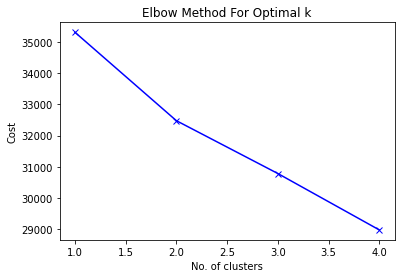

In [12]:
# Elbow curve to find optimal K -> silhoutte plot (zelfde als elbow curve)
cost = []
K = range(1,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(data)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

#### 3. Initializing clusters
Eventually I can code the Initialization method for categorical data clustering in (Cao, Liang, & Bai, 2009)

#### 4. Model
source code: https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/

In [13]:
# Building the model with n clusters
# Change value for n_clusters in case you want to run for other amount of clusters
kmode = KModes(n_clusters=2, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(data)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 494, cost: 32391.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 67, cost: 34814.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 141, cost: 33808.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 449, cost: 32878.0
Run 4, iteration: 2/100, moves: 0, cost: 32878.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 852, cost: 32391.0
Best run was number 1


array([0, 0, 0, ..., 1, 0, 1], dtype=uint16)

#### 3. Add cluster info

In [47]:
# Finally, insert the predicted cluster values in our original dataset.
data.insert(0, "Cluster", clusters, True)
data.head()

,Cluster,Cluster,linkid,sortnr,kritnr,kritwert,Count
0,0,0,1911903,1840,33,407.955,7674
1,0,0,1911903,1890,33,407.955,7674
2,0,0,1911903,1940,33,407.955,7674
3,0,0,1911903,1990,33,407.955,7674
4,0,0,1911903,2040,33,407.955,7674


In [46]:
data[data['Cluster'] == 1].head()

,Cluster,linkid,sortnr,kritnr,kritwert,Count
20,1,3096536,3,100,VA,5930
22,1,3096537,3,100,VA,5930
24,1,3096544,3,100,HA,5611
42,1,3096547,3,100,VA,5930
44,1,3096548,3,100,VA,5930


In [45]:
data[data['Cluster'] == 0].head()

,Cluster,linkid,sortnr,kritnr,kritwert,Count
0,0,1911903,1840,33,407.955,7674
1,0,1911903,1890,33,407.955,7674
2,0,1911903,1940,33,407.955,7674
3,0,1911903,1990,33,407.955,7674
4,0,1911903,2040,33,407.955,7674


#### 4. Ranking phase

Ranking phase for determining the set of most likely outliers (Suri, Murty, & Athithan, 2012)

2 types of errors:
- Type 1: either the categorical values describing that object are relatively infrequent
- Type 2: the combination of the categorical values describing that object is relatively infrequent

- code runnen voor datasets / parameter optimalizatie (K)
- Wat gebeurd in function?
- Welke afstand maat wordt gebruikt
- Hoe wordt centrum berekend / hoe wordt modus gedefinieerd
- Afhankelijk van definitie van outliers, andere afstandsmaat gebruiken
- Stap om Outliers eruit te halen in code schrijven (manual).

### 2) Isolation Forest

In [40]:
data = masterlist.iloc[:, :15]
data = data.head(50000)

In [41]:
# Create a label encoder
le = LabelEncoder()

# Fit the label encoder to each column
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = le.fit_transform(data[column])

In [ ]:
import numpy as np
from sklearn.ensemble import IsolationForest

# Create an Isolation Forest model
model = IsolationForest(n_estimators=100)

# Fit the model to the data
model.fit(data)

# Get the anomaly scores
anomalies = model.predict(data)

# Get the confidence scores
confidence = model.decision_function(data)

# Print the anomalies and their confidence scores
for i in range(1, len(anomalies)):
    if anomalies[i] == -1:
        print("Anomaly:", data[i - 1], "(confidence:", confidence[i], ")")
